# **PCLab#2**

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime
import time
import plotly.io as pio
import requests
import plotly.graph_objs as go
import numpy as np

In [14]:
df_data = pd.read_csv('Data_PCLab1_Stock.csv')
# apply corrections to the df
df_data["Date"] = pd.to_datetime(df_data["Date"])
df_data.set_index('Date', inplace=True)

df_data

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,60.198570,75.510002,30.120001,12.130000,175.929993,180.550003,28.250000,313.644379,1295.500000
2012-01-13,59.972858,74.599998,30.070000,12.350000,178.419998,179.160004,22.790001,311.328064,1289.089966
2012-01-17,60.671429,75.239998,30.250000,12.250000,181.660004,180.000000,26.600000,313.116364,1293.670044
2012-01-18,61.301430,75.059998,30.330000,12.730000,189.440002,181.070007,26.809999,315.273285,1308.040039
2012-01-19,61.107143,75.559998,30.420000,12.800000,194.449997,180.520004,26.760000,318.590851,1314.500000
...,...,...,...,...,...,...,...,...,...
2020-08-05,440.250000,174.279999,29.850000,16.719999,3205.030029,125.449997,1485.020020,1473.609985,3327.770020
2020-08-06,455.609985,172.199997,29.840000,18.459999,3225.000000,126.120003,1489.579956,1500.099976,3349.159912
2020-08-07,444.450012,170.020004,30.020000,19.030001,3167.459961,124.959999,1452.709961,1494.489990,3351.280029


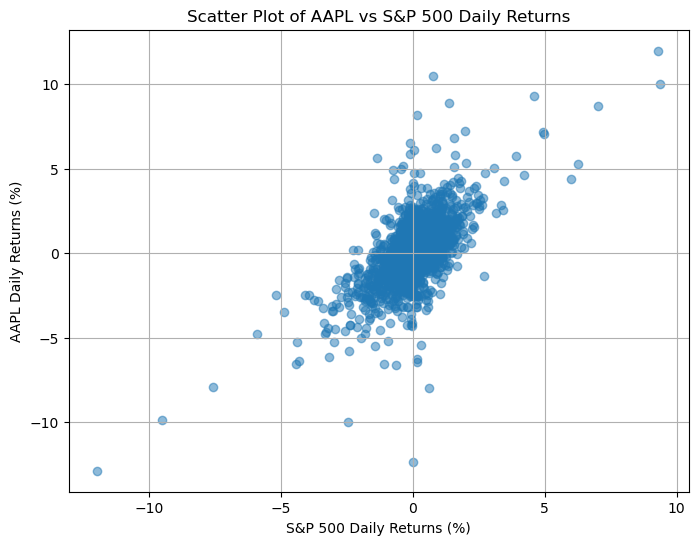

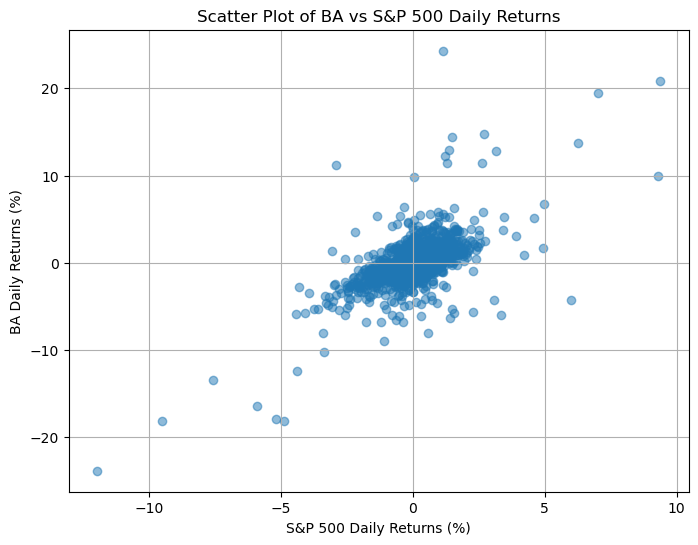

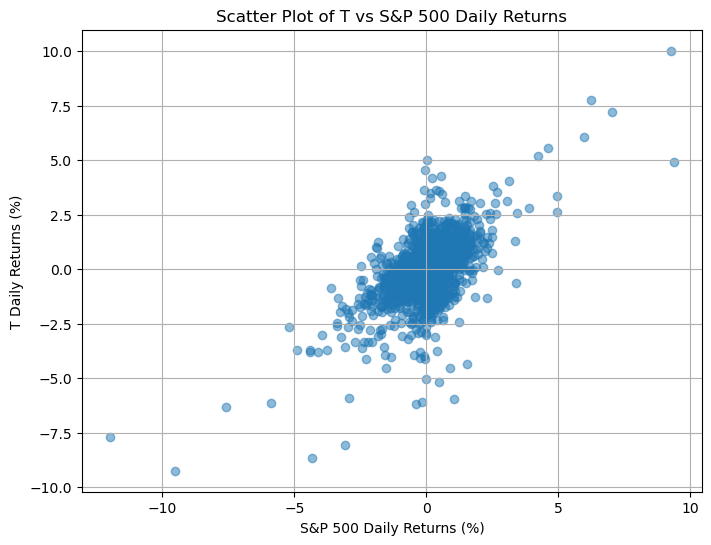

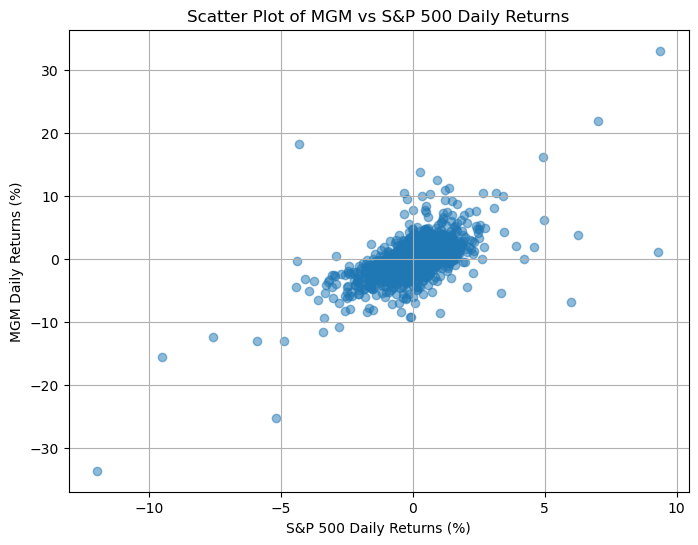

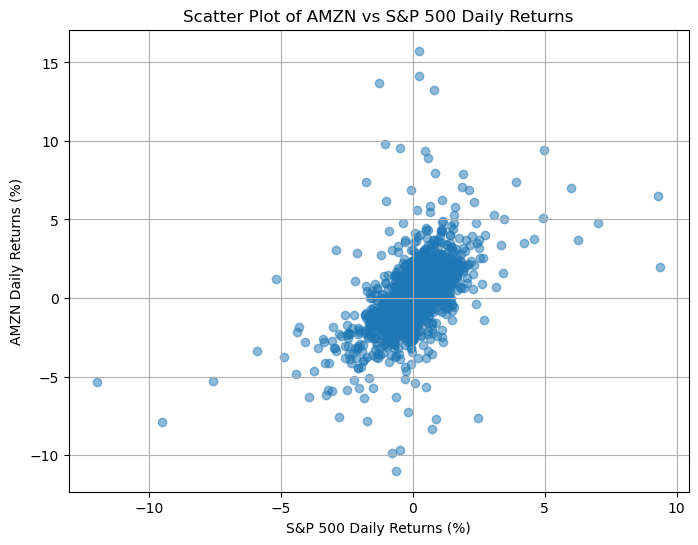

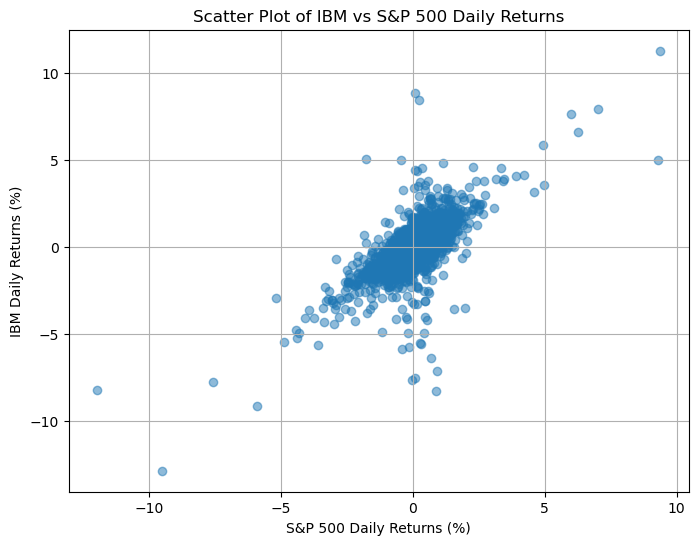

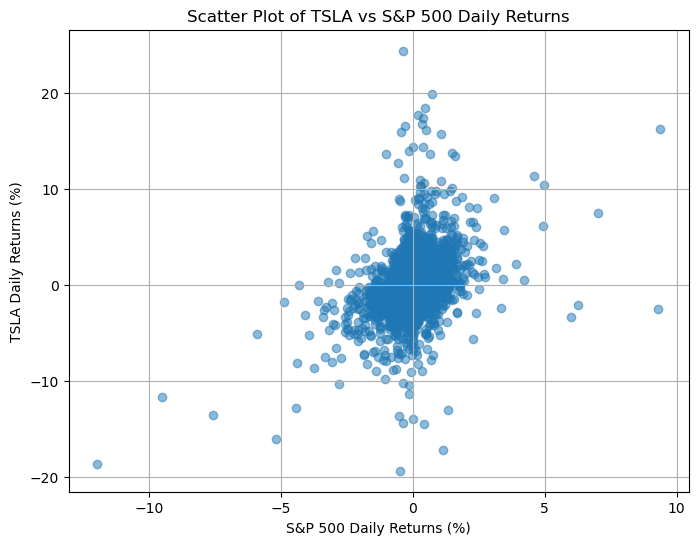

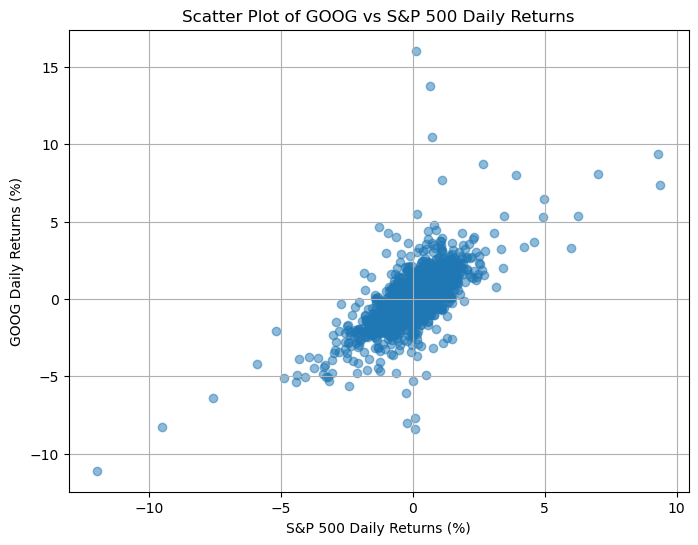

In [16]:
# Calculate daily returns (in %) for each stock and the S&P 500
#df_data = df_data.set_index('Date')  # Set Date as the index if it isn't already
daily_returns = df_data.pct_change() * 100  # Calculate daily returns in %

# Plot scatter plots of each stock against the S&P 500 daily returns
sp500_returns = daily_returns['sp500']  # Extract S&P 500 daily returns

# Loop through each stock column (excluding the S&P 500)
for stock in daily_returns.columns:
    if stock != 'sp500':
        plt.figure(figsize=(8, 6))
        plt.scatter(sp500_returns, daily_returns[stock], alpha=0.5)
        plt.xlabel("S&P 500 Daily Returns (%)")
        plt.ylabel(f"{stock} Daily Returns (%)")
        plt.title(f"Scatter Plot of {stock} vs S&P 500 Daily Returns")
        plt.grid(True)
        plt.show()

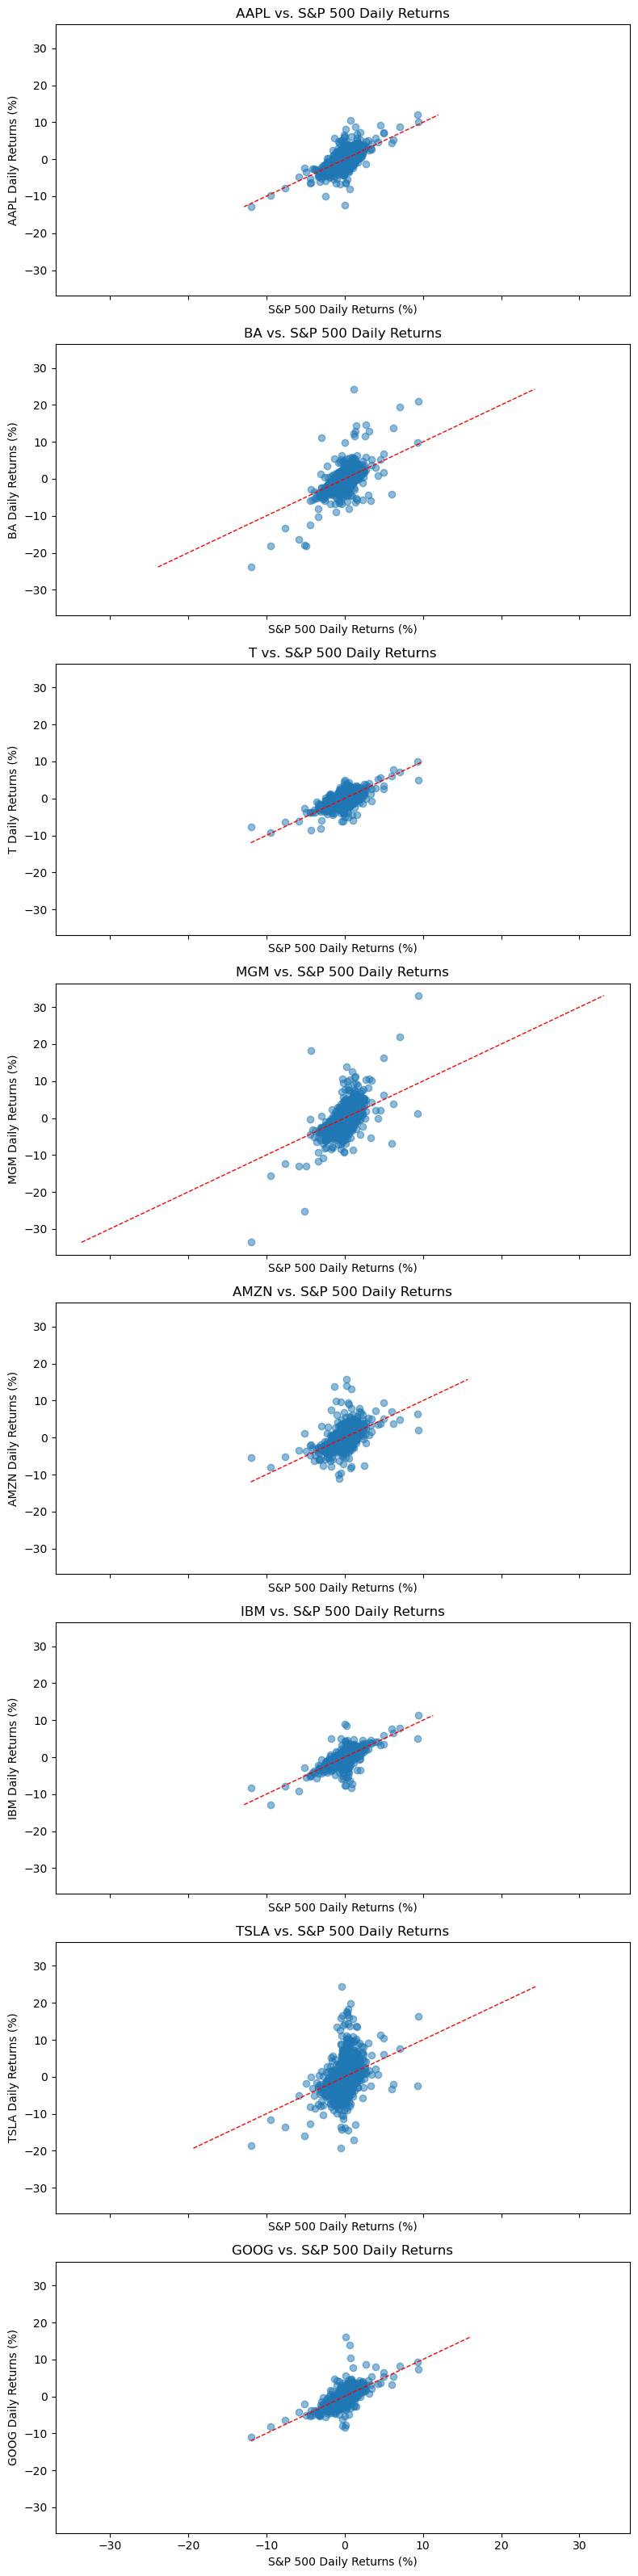

In [18]:
# Calculate daily returns (in percentage)
daily_returns = df_data.pct_change() * 100

# Drop any rows with NaN values from the percent change calculation
daily_returns.dropna(inplace=True)

# Plot each stock's daily returns against the S&P 500's daily returns
sp500_returns = daily_returns['sp500']

# Set up a grid for subplots
num_stocks = len(daily_returns.columns) - 1  # Exclude 'sp500' column
fig, axes = plt.subplots(nrows=num_stocks, figsize=(8, num_stocks * 4), sharex=True, sharey=True)

for i, stock in enumerate(daily_returns.columns.drop('sp500')):
    ax = axes[i]
    stock_returns = daily_returns[stock]

    # Scatter plot
    ax.scatter(sp500_returns, stock_returns, alpha=0.5)
    
    # Plot the 45° line
    max_val = max(sp500_returns.max(), stock_returns.max())
    min_val = min(sp500_returns.min(), stock_returns.min())
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1)

    # Labels and titles
    ax.set_title(f'{stock} vs. S&P 500 Daily Returns')
    ax.set_xlabel('S&P 500 Daily Returns (%)')
    ax.set_ylabel(f'{stock} Daily Returns (%)')

plt.tight_layout()
plt.show()

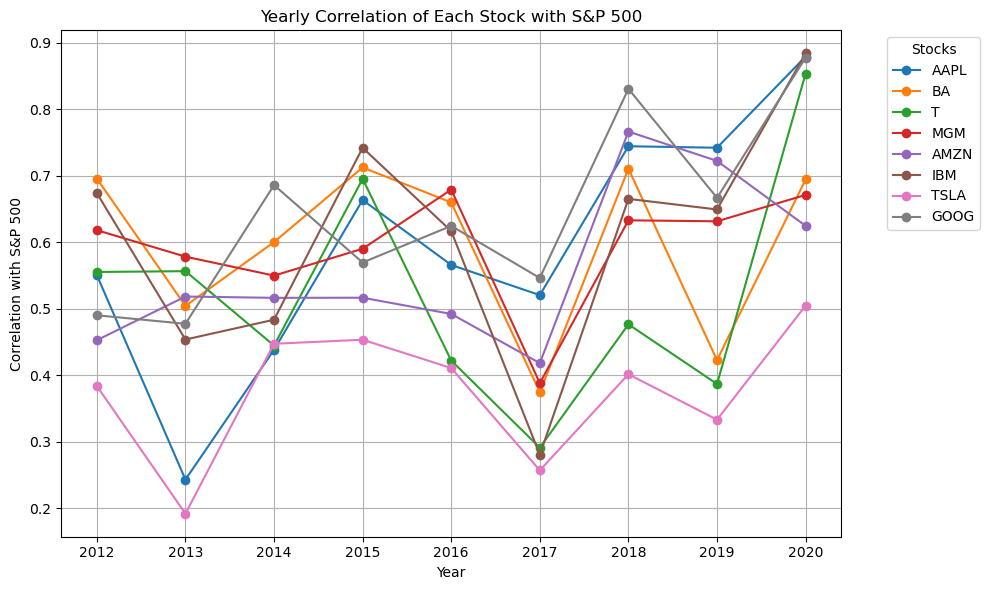

In [19]:
# Calculate daily returns
daily_returns = df_data.pct_change() * 100
daily_returns.dropna(inplace=True)

# Create an empty DataFrame to store yearly correlations
years = daily_returns.index.year.unique()
correlation_df = pd.DataFrame(index=years)

# Calculate the correlation for each stock with the S&P 500 for each year
for stock in daily_returns.columns.drop('sp500'):
    yearly_corr = daily_returns.groupby(daily_returns.index.year).apply(
        lambda x: x[stock].corr(x['sp500'])
    )
    correlation_df[stock] = yearly_corr

# Plotting
plt.figure(figsize=(10, 6))
for stock in correlation_df.columns:
    plt.plot(correlation_df.index, correlation_df[stock], marker='o', label=stock)

plt.title('Yearly Correlation of Each Stock with S&P 500')
plt.xlabel('Year')
plt.ylabel('Correlation with S&P 500')
plt.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Apply the CAPM : run an OLS regression of stock i returns on market returns, over the whole period. Assume rf = 0.

In [23]:
returns = df_data.pct_change() * 100
returns.dropna(inplace=True)

# DataFrame to store the statistics for each stock
stats_df = pd.DataFrame(columns=['Beta', 'Alpha', 'R_squared', 'Adj_R_squared'])

# Run OLS regression for each stock
for stock in returns.columns.drop('sp500'):
    X = returns['sp500']  # Independent variable: S&P 500 returns
    y = returns[stock]    # Dependent variable: Stock returns
    X = sm.add_constant(X)  # Add a constant to capture alpha

    model = sm.OLS(y, X).fit()  # Fit the regression model

    # Extract metrics
    alpha = model.params['const']
    beta = model.params['sp500']
    r_squared = model.rsquared
    adj_r_squared = model.rsquared_adj

    # Store metrics in the DataFrame
    stats_df.loc[stock] = [beta, alpha, r_squared, adj_r_squared]

# Display the final DataFrame
print(stats_df)

          Beta     Alpha  R_squared  Adj_R_squared
AAPL  1.112891  0.052837   0.432070       0.431807
BA    1.382867 -0.002292   0.411941       0.411668
T     0.744630 -0.028577   0.381261       0.380974
MGM   1.653568 -0.016893   0.398728       0.398449
AMZN  0.991732  0.102261   0.291125       0.290796
IBM   0.960416 -0.053480   0.495525       0.495291
TSLA  1.268611  0.175917   0.150482       0.150088
GOOG  1.034881  0.033371   0.468638       0.468392


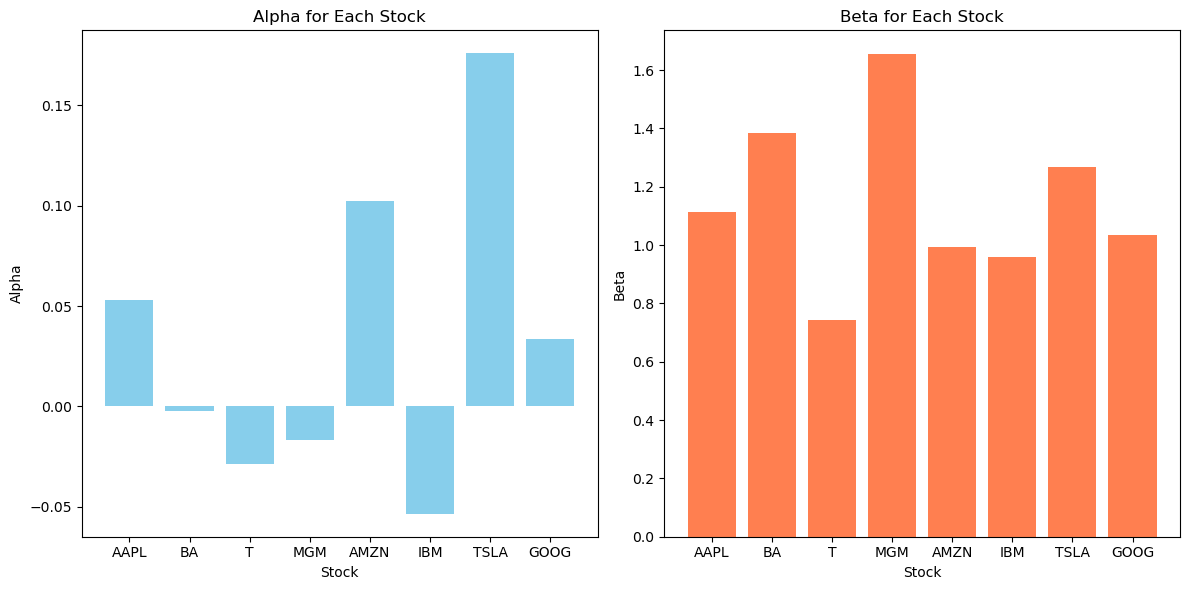

In [24]:
# Plot Alpha values
plt.figure(figsize=(12, 6))

# Alpha plot
plt.subplot(1, 2, 1)
plt.bar(stats_df.index, stats_df['Alpha'], color='skyblue')
plt.title("Alpha for Each Stock")
plt.xlabel("Stock")
plt.ylabel("Alpha")

# Beta plot
plt.subplot(1, 2, 2)
plt.bar(stats_df.index, stats_df['Beta'], color='coral')
plt.title("Beta for Each Stock")
plt.xlabel("Stock")
plt.ylabel("Beta")

plt.tight_layout()
plt.show()

In [25]:
highest_alpha_stock = stats_df['Alpha'].idxmax()
lowest_alpha_stock = stats_df['Alpha'].idxmin()
highest_beta_stock = stats_df['Beta'].idxmax()
lowest_beta_stock = stats_df['Beta'].idxmin()

print(f"Highest Alpha: {highest_alpha_stock} ({stats_df['Alpha'].max():.4f})")
print(f"Lowest Alpha: {lowest_alpha_stock} ({stats_df['Alpha'].min():.4f})")
print(f"Highest Beta: {highest_beta_stock} ({stats_df['Beta'].max():.4f})")
print(f"Lowest Beta: {lowest_beta_stock} ({stats_df['Beta'].min():.4f})")

Highest Alpha: TSLA (0.1759)
Lowest Alpha: IBM (-0.0535)
Highest Beta: MGM (1.6536)
Lowest Beta: T (0.7446)


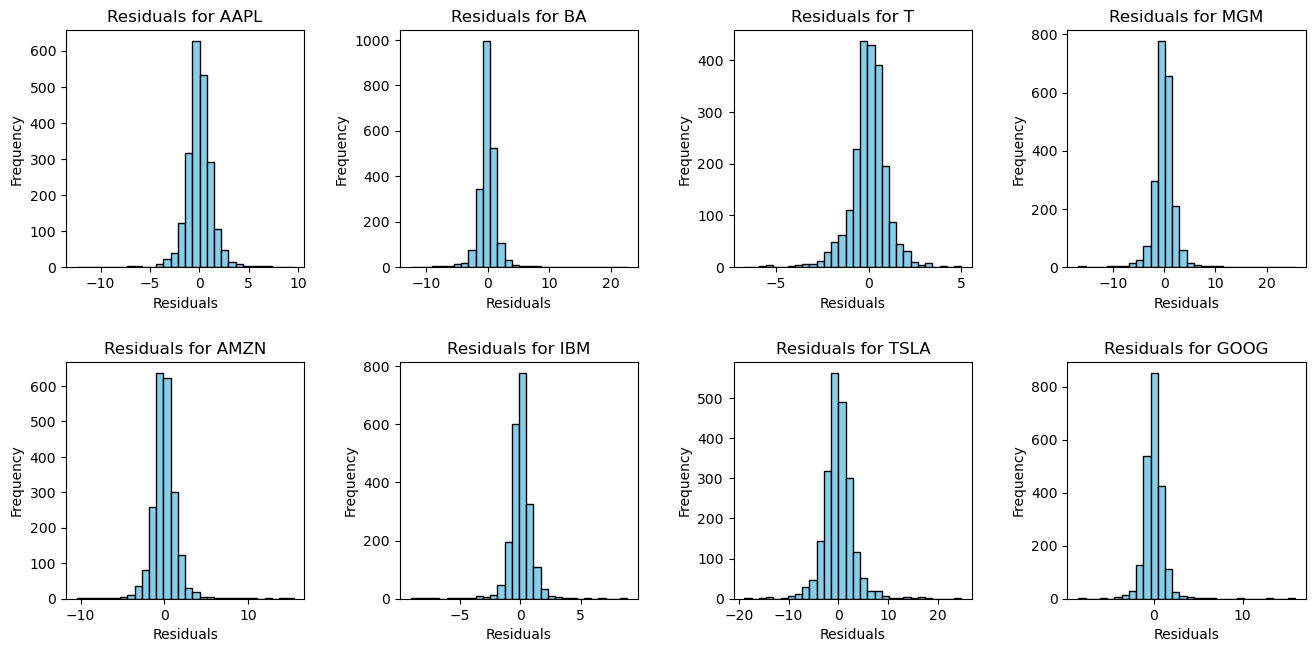

In [27]:
# Initialize an empty dictionary to store residuals for each stock
residuals = {}

# Set up the 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()  # Flatten for easy iteration
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through each stock to run the OLS regression and compute residuals
for i, stock in enumerate(returns.columns.drop('sp500')):
    X = returns['sp500']  # Independent variable: S&P 500 returns
    y = returns[stock]    # Dependent variable: Stock returns
    X = sm.add_constant(X)  # Add a constant term to capture alpha

    # Fit the model and obtain predictions
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # Calculate residuals (observed - predicted)
    residuals[stock] = y - predictions

    # Plot the residual histogram in the subplot
    axes[i].hist(residuals[stock], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Residuals for {stock}')
    axes[i].set_xlabel('Residuals')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [31]:
capm_params = stats_df
# Step 1: Calculate the volatility (standard deviation) of each stock's returns
volatilities = returns.std()

# Select the 4 stocks with the highest volatilities
riskier_assets = volatilities.nlargest(4).index
print("Selected risky assets:", riskier_assets)

# Step 2: Form an equally weighted portfolio
weights = np.full(4, 1/4)  # Equal weights (0.25 for each asset)

# Step 3: Estimate the expected return for each risky asset using CAPM
portfolio_expected_return = 0
for stock in riskier_assets:
    beta = capm_params.loc[stock, 'Beta']
    alpha = capm_params.loc[stock, 'Alpha']
    market_return = returns['sp500'].mean()  # Assuming historical average as expected market return
    
    # Expected return for each risky stock
    expected_return = alpha + beta * market_return
    portfolio_expected_return += expected_return * weights[riskier_assets.get_loc(stock)]

print("Estimated Portfolio Expected Return:", portfolio_expected_return)

Selected risky assets: Index(['TSLA', 'MGM', 'BA', 'AMZN'], dtype='object')
Estimated Portfolio Expected Return: 0.13008253649018653


In [50]:
# Step 1: Calculate daily returns in % and store in df_returns
df_returns = df_data.pct_change() * 100
df_returns = df_returns.iloc[1:]

# Step 2: Initialize a dictionary to store results
all_results = {}

# Loop over each year in df_returns to compute beta and alpha
for year in list(range(2012, 2021)):
    # Filter rows for the current year only
    df_year = df_returns[df_returns.index.year == year]
    
    # Initialize a dictionary for the current year in all_results
    all_results[year] = {}
    
    # Run the OLS regression for each stock on S&P 500
    for stock in df_year.columns:
        if stock == 'sp500':  # Skip the S&P 500 column itself
            continue
        
        # Define dependent (Y) and independent (X) variables for OLS regression
        Y = df_year[stock]
        X = df_year['sp500']
        
        # Add a constant to the independent variable for the intercept (alpha)
        X = sm.add_constant(X)
        
        # Fit the OLS regression model
        model = sm.OLS(Y, X).fit()
        
        # Store beta and alpha values in all_results for the current stock and year
        all_results[year][stock] = {
            'beta': model.params['sp500'],   # β coefficient
            'alpha': model.params['const'],  # α coefficient
        }

# all_results will contain {2012: {'AAPL': {'beta': 0.1, 'alpha': 0.09}, ... }, ... }
print(all_results)

{2012: {'AAPL': {'beta': 1.283027738940946, 'alpha': 0.05893097023194663}, 'BA': {'beta': 1.0246158580752192, 'alpha': -0.03781440688210343}, 'T': {'beta': 0.6162648735132784, 'alpha': 0.02406995674053493}, 'MGM': {'beta': 1.732747308066556, 'alpha': -0.06608706744447272}, 'AMZN': {'beta': 1.123073625904686, 'alpha': 0.11802698505248606}, 'IBM': {'beta': 0.8566190880679744, 'alpha': -0.007105190986715273}, 'TSLA': {'beta': 1.6114165152852131, 'alpha': 0.06381404271208752}, 'GOOG': {'beta': 0.8603343617128555, 'alpha': 0.021343354102893154}}, 2013: {'AAPL': {'beta': 0.6265656188230017, 'alpha': -0.028696726797481024}, 'BA': {'beta': 0.9666729081540439, 'alpha': 0.1430012630798398}, 'T': {'beta': 0.7845433985651338, 'alpha': -0.061123682277229946}, 'MGM': {'beta': 1.526287996011202, 'alpha': 0.1355662659960069}, 'AMZN': {'beta': 1.2654663858581605, 'alpha': 0.06510959697877133}, 'IBM': {'beta': 0.7654909542429027, 'alpha': -0.08199914694367968}, 'TSLA': {'beta': 1.174505125789214, 'alpha